# Feature extraction with VGG19

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 04:42:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   108MB/s    in 0.6s    

2019-04-18 04:42:45 (108 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile
from google.colab import files

from keras.applications import VGG19
from keras import layers
from keras import models
from keras import optimizers
from keras.regularizers import l1
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

import numpy as np

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Using TensorFlow backend.


In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Load the convolutional base and freeze it

In [4]:
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


## Create model to put on top of VGG19

This model contains densely connected layers that will use the features extracted from the convolutional base to classify images as either cats or dogs.  Because these models suffer greatly from overfitting, we use a high drop out rate for the dense layer, as well decreasing the size of the dense layer in order to reduce the complexity of the model and further fight overfitting. 

In [5]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [7]:
# Use batches of powers of two to take advantage of GPU.
batches = 32
val_steps = int(1000/batches)
train_steps = int(2000/batches)

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


# Compile model with Adam as optimizer.
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=1e-5), 
    metrics=['acc'])

# Training phase
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=val_steps
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
62/62 [==============================] - 21s 346ms/step - loss: 0.7225 - acc: 0.5181 - val_loss: 0.6570 - val_acc: 0.6351
Epoch 2/40
62/62 [==============================] - 17s 273ms/step - loss: 0.6750 - acc: 0.5872 - val_loss: 0.6118 - val_acc: 0.6994
Epoch 3/40
62/62 [==============================] - 16s 250ms/step - loss: 0.6358 - acc: 0.6341 - val_loss: 0.5694 - val_acc: 0.7552
Epoch 4/40
62/62 [==============================] - 17s 278ms/step - loss: 0.6084 - acc: 0.6749 - val_loss: 0.5356 - val_acc: 0.7686
Epoch 5/40
62/62 [==============================] - 16s 257ms/step - loss: 0.5844 - acc: 0.7001 - val_loss: 0.5129 - val_acc: 0.7779
Epoch 6/40
62/62 [==============================] - 16s 253ms/step - loss: 0.5823 - acc: 0.6956 - val_loss: 0.4851 - val_acc: 0.7924
Epoch 7/40
62/62 [==============================] - 16s 257ms/step - l

## Display curves of loss and accuracy during training

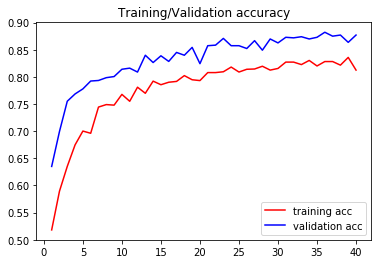

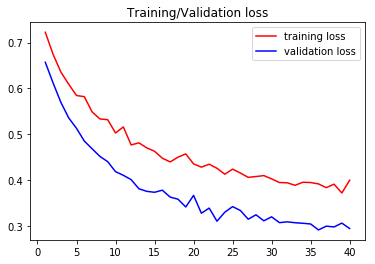

In [8]:
def plot_graphs(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  # training and validation accuracy

  plt.plot(epochs, acc, 'r', label='training acc')
  plt.plot(epochs, val_acc, 'b', label='validation acc')
  plt.title('Training/Validation accuracy')
  plt.legend()

  plt.figure()

  # training and validation loss

  plt.plot(epochs, loss, 'r', label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.title('Training/Validation loss')
  plt.legend()

  plt.show()

plot_graphs(history)

While there appears to be underfitting, this is because of the dropout, and in reality both training and validation are steadily improving, and hopefully can be improved further.

## Train with smaller learning rates

No fine-tuning is done to the model, but a learning rate scheduler is applied.

In [0]:
# Establish the schedule for learning rate decrease.
def lr_schedule(epoch):
  
  lr = 1e-5
  
  if epoch > 75:
      lr *= 1e-3
  elif epoch > 50:
      lr *= 1e-2
  elif epoch > 25:
      lr *= 1e-1
  return lr

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=lr_schedule(0)), 
    metrics=['acc'])

model_type = "VGG19"
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')

# Every time the model has a better validation accuracy than before, update the saved model.
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate scheduling.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# Create the learning rate scheuler and reducer to monitor the model.
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-8)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the model.
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps,
    workers=4,
    callbacks=callbacks)

Epoch 1/100
62/62 [==============================] - 16s 256ms/step - loss: 0.3842 - acc: 0.8286 - val_loss: 0.2902 - val_acc: 0.8781

Epoch 00001: val_acc improved from -inf to 0.87810, saving model to /content/saved_models/cifar10_VGG19_model.001.h5
Epoch 2/100
62/62 [==============================] - 13s 211ms/step - loss: 0.3801 - acc: 0.8231 - val_loss: 0.2987 - val_acc: 0.8750

Epoch 00002: val_acc did not improve from 0.87810
Epoch 3/100
62/62 [==============================] - 13s 215ms/step - loss: 0.3737 - acc: 0.8327 - val_loss: 0.2953 - val_acc: 0.8740

Epoch 00003: val_acc did not improve from 0.87810
Epoch 4/100
62/62 [==============================] - 15s 241ms/step - loss: 0.3889 - acc: 0.8231 - val_loss: 0.2819 - val_acc: 0.8895

Epoch 00004: val_acc improved from 0.87810 to 0.88946, saving model to /content/saved_models/cifar10_VGG19_model.004.h5
Epoch 5/100
62/62 [==============================] - 13s 217ms/step - loss: 0.3660 - acc: 0.8432 - val_loss: 0.2892 - val_a

## Display Fine-Tuning Train/Validation Accuracy/Loss Graphs

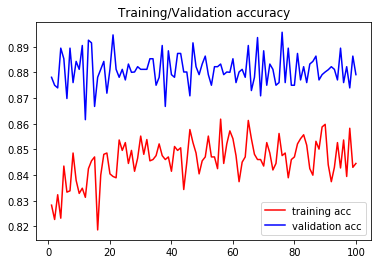

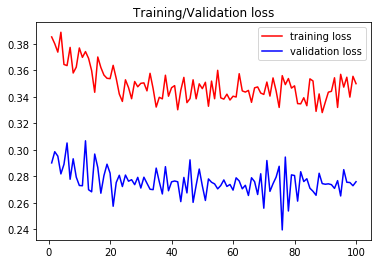

In [11]:
plot_graphs(history)

In [23]:
!ls /content/saved_models/ | tail -1

cifar10_VGG19_model.076.h5


In [0]:
cp /content/saved_models/cifar10_VGG19_model.076.h5 /content/VGG19_P1_best.h5

## Print out Evaluation Validation Loss/Accuracy

In [25]:
from keras.models import load_model

model = load_model('VGG19_P1_best.h5')
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=val_steps)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [26]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.25414792983985146
Validation accuracy: 0.8863636363636364


## Save the best model

In [0]:
model_name = 'VGG19_P1_best.h5'
with open(model_name, 'r') as f:
  files.download(model_name)